# Exploration of OMdb data #

1. [Introducing the data](#intro)<br>
1.1 [Merging & Subsetting](#merge)<br>
1.2 [Data Dictionary & Definitions](#dict)
2. [Data Cleaning](#clean)
3. [Feature Engineering](#feature)
4. [Missing Values](#miss)
5. [Exploration of Relationships](#explore)
6. [Discussion](#discussion)



<h2> <a name="intro">1. Introducing the data</a></h2>


The OMdb data has two main components. The **search parameters** contained in the `OMdb_search_dat` JSON file, which contain the keyword search strings and IMdb IDs used to query the OMdb API. Crucially, each search string and unique IMdb ID contains a corresponding unique iTunes ID, which will then be used to join the iTunes data and the OMdb data.

The `OMdb_data` JSON file contains the **results** that have come back from the OMdb API. These contain information on the movie, including information on the cast, box office returns, critic ratings, 


In [1]:
import pandas as pd
from pandas.io import sql
import json
import regex as re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import import_ipynb
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/anaconda/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


<h2> <a name="merge">1.1 Merging and Subsetting </a></h2>

The search results and search parameters will now have to be merged. This will be achieved through an inner join using `pd.merge` on the IMdb ID that was used to query the OMdb API. I have also subsetted the data to select more relevant features, discarding features that are only relevant to episode-type titles, since we're analysing movies.


In [2]:
## Read in data and rename Columns ## 

# Search data, used to query the OMdb API #
OMdb_search_dat_df=pd.read_json('../data/OMdb_search_dat.json',orient='columns')
OMdb_search_dat_df.columns= ['IMdb_ID', 'TMdb_ID', 'iTunes_ID', 'search_strs', 'titles', 'years']

# Results gotten after the query # 
OMdb_results_df=pd.read_json('../data/OMdb_data.json',orient='records')

# Rename columns # 
OMdb_orig_features=['Actors', 'Awards', 'BoxOffice', 'Country', 'DVD', 'Director',\
        'Genre', 'IMdb_score', 'Language', \
       'Metascore', 'Plot', 'Production', 'RT_score', 'Rated',\
       'Released', 'Runtime', 'Title', 'Type', 'Website',\
        'Year', 'actor_1', 'actor_2', 'director_1', 'director_2',\
       'imdbID', 'imdbVotes', 'num_actor',\
       'num_director']

OMdb_features=['Actors', 'Awards', 'BoxOffice', 'Country', 'DVD', 'Director',\
        'Genre', 'IMdb_score', 'Language', \
       'Metascore', 'Plot',  'Production', 'RT_score', 'Rated',\
       'Released', 'Runtime', 'Title', 'Type', 'Website',\
        'Year', 'actor_1', 'actor_2', 'director_1', 'director_2',\
       'IMdb_ID',  'imdbVotes', 'num_actor', \
       'num_director']
OMdb_df=OMdb_results_df[OMdb_orig_features]
OMdb_df.columns=OMdb_features

In [3]:
# Join on IMdb ID # 
OMdb=OMdb_df.merge(OMdb_search_dat_df,how='inner',on='IMdb_ID')

In [4]:
OMdb.dtypes

Actors           object
Awards           object
BoxOffice        object
Country          object
DVD              object
Director         object
Genre            object
IMdb_score      float64
Language         object
Metascore        object
Plot             object
Production       object
RT_score        float64
Rated            object
Released         object
Runtime          object
Title            object
Type             object
Website          object
Year             object
actor_1          object
actor_2          object
director_1       object
director_2       object
IMdb_ID          object
imdbVotes        object
num_actor         int64
num_director      int64
TMdb_ID          object
iTunes_ID         int64
search_strs      object
titles           object
years             int64
dtype: object

<h2><a name="dict">1.2 Data Dictionary & Definitions</a></h2>

This is a description of most of the features that will be relevant in the analysis. For a full description, please look up the [OMdb API documentation](http://www.omdbapi.com/). Certain variables, such as `actor_1` and `actor_2` have already been parsed from the JSON file during the [data collection process](https://github.com/zacharyang/movies-project/tree/master/data). Further pre-processing is necessary and will be explored in the subsequent steps.  

| Variable Name |  Type   |Description|
| :----------:  | :-----: |:------------:|
|     Actors   | String | List of actors credit to the movie separated by commas|
|     Awards    | String | Description of number of awards and nominations for the movie|
|     Country | String| List of countries that the movie is set in, separated by commas |
|     DVD     | String | Date released on DVD |
|     Director   |  String | List of actors credit to the movie separated by commas|
|     IMdb_score    | Float| IMdb rating for the movie, ranging from 0 to 100|
|    Language  | String | List of languages that the movie is released in, separated by commas |
|     Metascore   | String | Metascore rating for the movie, ranging from 0 to 100 |
|     Plot  |  String| Synopsis of the movie|
|     Production     | Float | Production Studio that produced the movie |
|     RT_score   | Float | Rotten Tomatoes rating for the movie, ranging from 0 to 100 |
|     Title    | String | Movie Title |
|     imdbVotes   |  Float | Number of votes on IMdb|
|     Runtime     | String | Run Time of movie in minutes|
|     Year  | String | Year of Release |
|     actor_1   | String | First credited actor in the "Actors" column. Parsed out in `collect_data.py` |
|     actor_2    | Float | Second credited actor in the "Actors" column. Parsed out in `collect_data.py` |
|     num_actor   |  Float | Number of actors credited |
|     director_1      | String | First credited Director in the "Director" column. Parsed out in `collect_data.py`|
|     director_2  | String | Second credited Director in the "Director" column. Parsed out in `collect_data.py` |
|     num_director   | Float | Number of directors credited |
|     IMdb_ID  |  String | Unique IMdb ID taking the form of "tt" + 9-digit string|
|     TMdb_ID     | String | Possible TMdb IDs obtained from TMdb API queries. Could be a string or a single unique ID|
|     iTunes_ID    | String | Unique iTunes ID as listed on iTunes Store|
|     search_strs      | String | Movie Title transformed to pass through a search string, eg. "Field+of+Dreams"|


<h2><a name="clean"> 2. Data Cleaning</a></h2>

Data's fairly dirty so there's still a fair bit of cleaning to be done: 
* Convert Metascores to float (originally in String)
* Convert IMdbVotes to Int (originally in String)
* Convert BoxOffice to float (originally in String)
* Convert Year to int (originally in String)
* Convert Runtime to float (originally to string) 

In [5]:
# Metascore, str to float # 
OMdb['Metascore']=OMdb['Metascore'].apply(lambda x : np.nan if x=='N/A' else float(x))

# Imdbvotes, str to int # 
OMdb['imdbVotes']=OMdb['imdbVotes'].apply(lambda x : np.nan if x=='N/A' else int(x.replace(',','')))

# BoxOffice, str to float # 
OMdb['BoxOffice']=OMdb['BoxOffice'].apply(lambda x: np.nan if x == 'N/A' else x)\
.apply(lambda x: float(x.replace('$','').replace(',','')) if type(x)==str else x)

# Year, str to int # 
OMdb['Year']=OMdb['Year'].apply(lambda x: int(x.strip('–')))

# Runtime, str to float # 
OMdb['Runtime']= OMdb['Runtime'].apply(lambda x: np.nan if x=='N/A' else float(x.replace(' min','')) )

<h2><a name="feature">3. Feature Engineering</a></h2>

I'll be doing some feature engineering to extract more useful information out of the existing data. I'll be looking specifically at the `Awards`, `Language` and `Genre` column. 

For `Awards`, the expressions used are fairly regular, so I'll be using regex to parse each row to extract the number of awards and nominations for each movie. This would be fairly useful in trying to predict how successful a movie is, and in turn how much it can be priced in iTunes for. 

For `Languages` and `Genre`, each list of languages and genres for each movie are assigned to the movie in alphabetical order. While I can determine the number of movies, there might not be a systematic way to identify the primary language or primary genre of the movie. I'll settle for creating the number of languages and genre for now. 

Genre would be an important categorical variable that I might need to look at, but the iTunes data provides a unique, primary Genre feature, which I could use subsequently. 


In [6]:
# Parsing the Awards column to get number of awards # 

OMdb['oscar_wins']=OMdb['Awards'].apply(lambda x: 0 if re.search(r'Won (.*?) Oscar',x) == None \
                                        else float(re.search(r'Won (.*?) Oscar',x).group(1)))
OMdb['oscar_noms']=OMdb['Awards'].apply(lambda x: 0 if re.search(r'Nominated for (.*?) Oscar',x) == None \
                                        else float(re.search(r'Nominated for (.*?) Oscar',x).group(1)))
OMdb['nominations']=OMdb['Awards'].apply(lambda x: 0 if re.search(r'(\d+) nomination',x) == None \
                                         else float(re.search(r'(\d+) nomination',x).group(1)))
OMdb['awards']=OMdb['Awards'].apply(lambda x: 0 if re.search(r'(\d+) win',x) == None \
                                    else float(re.search(r'(\d+) win',x).group(1)))

In [7]:
OMdb[['Awards','oscar_wins','oscar_noms','nominations','awards']].head()

,Awards,oscar_wins,oscar_noms,nominations,awards
0,1 win & 1 nomination.,0.0,0.0,1.0,1.0
1,5 wins & 21 nominations.,0.0,0.0,21.0,5.0
2,14 nominations.,0.0,0.0,14.0,0.0
3,13 nominations.,0.0,0.0,13.0,0.0
4,Won 3 Oscars. Another 85 wins & 128 nominations.,3.0,0.0,128.0,85.0


In [8]:
# Number of languages movie is available in # 

OMdb['num_lang']=OMdb['Language'].apply(lambda x: np.nan if x =='N/A' else len(x.split(',')))

# Number of genres the movie can be classified under # 
OMdb['num_genre']=OMdb['Genre'].apply(lambda x: np.nan if x =='N/A' else len(x.split(',')))

In [9]:
OMdb[['Language','num_lang','Genre','num_genre']].head()

,Language,num_lang,Genre,num_genre
0,French,1.0,"Action, Crime, Drama, Thriller",4
1,"English, French, Tibetan, Mandarin, Russian, H...",10.0,"Action, Adventure, Sci-Fi",3
2,"Swahili, Nama, English, Xhosa, Korean",5.0,"Action, Adventure, Sci-Fi",3
3,English,1.0,"Action, Adventure, Comedy, Drama, Family, Sci-...",7
4,"English, Spanish",2.0,"Action, Adventure, Fantasy, Sci-Fi",4


<h2><a name="miss">4. Missing Values</a></h2>

Let's check for missing data here by tabulating missing data count per column. Credits to [Fabien Daniel's kernel](https://www.kaggle.com/fabiendaniel/film-recommendation-engine) for the following snippet of code. 

In [10]:
missing_df = OMdb.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (OMdb.shape[0] 
                                - missing_df['missing_count']) / OMdb.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
missing_df[missing_df['filling_factor']<100]

,column_name,missing_count,filling_factor
0,BoxOffice,238,63.043478
1,Metascore,70,89.130435
2,RT_score,61,90.527950
3,Production,3,99.534161
4,num_lang,3,99.534161
5,DVD,3,99.534161
6,Website,3,99.534161
7,Runtime,2,99.689441
8,IMdb_score,1,99.844720
9,imdbVotes,1,99.844720


In [11]:
print(OMdb['Title'][OMdb['BoxOffice'].isnull()].values[:10])

['The Professional' 'Gladiator' 'A Christmas Carol' 'Tomb Raider' 'Z Storm'
 'Commando' 'Star Wars: Episode VI - Return of the Jedi'
 'Star Wars: Episode IV - A New Hope' 'Frozen' 'Beirut']


We have quite a lot of missing data for box office earnings, which I suspect will be quite important in predicting how "hot" a movie is and how much it can be priced for on the iTunes store. Looking at some of the movies, I'm fairly certain we can find the box office earnings on open source. I'll be using the dataset from Box Office Mojo to supplement this. 

The next two most common missing data categories are the ratings score from Metacritic and Rotten Tomatoes. Rotten Tomatoes has a fairly involved compliance process to get yourself onto their API, so I'm not sure if it's worth the effort for the remaining 10% of missing values. I think IMdb ratings and IMdb votes would be a good linear predictor of RT and Metacritic scores, so I'll probably rely on linear regression imputation.

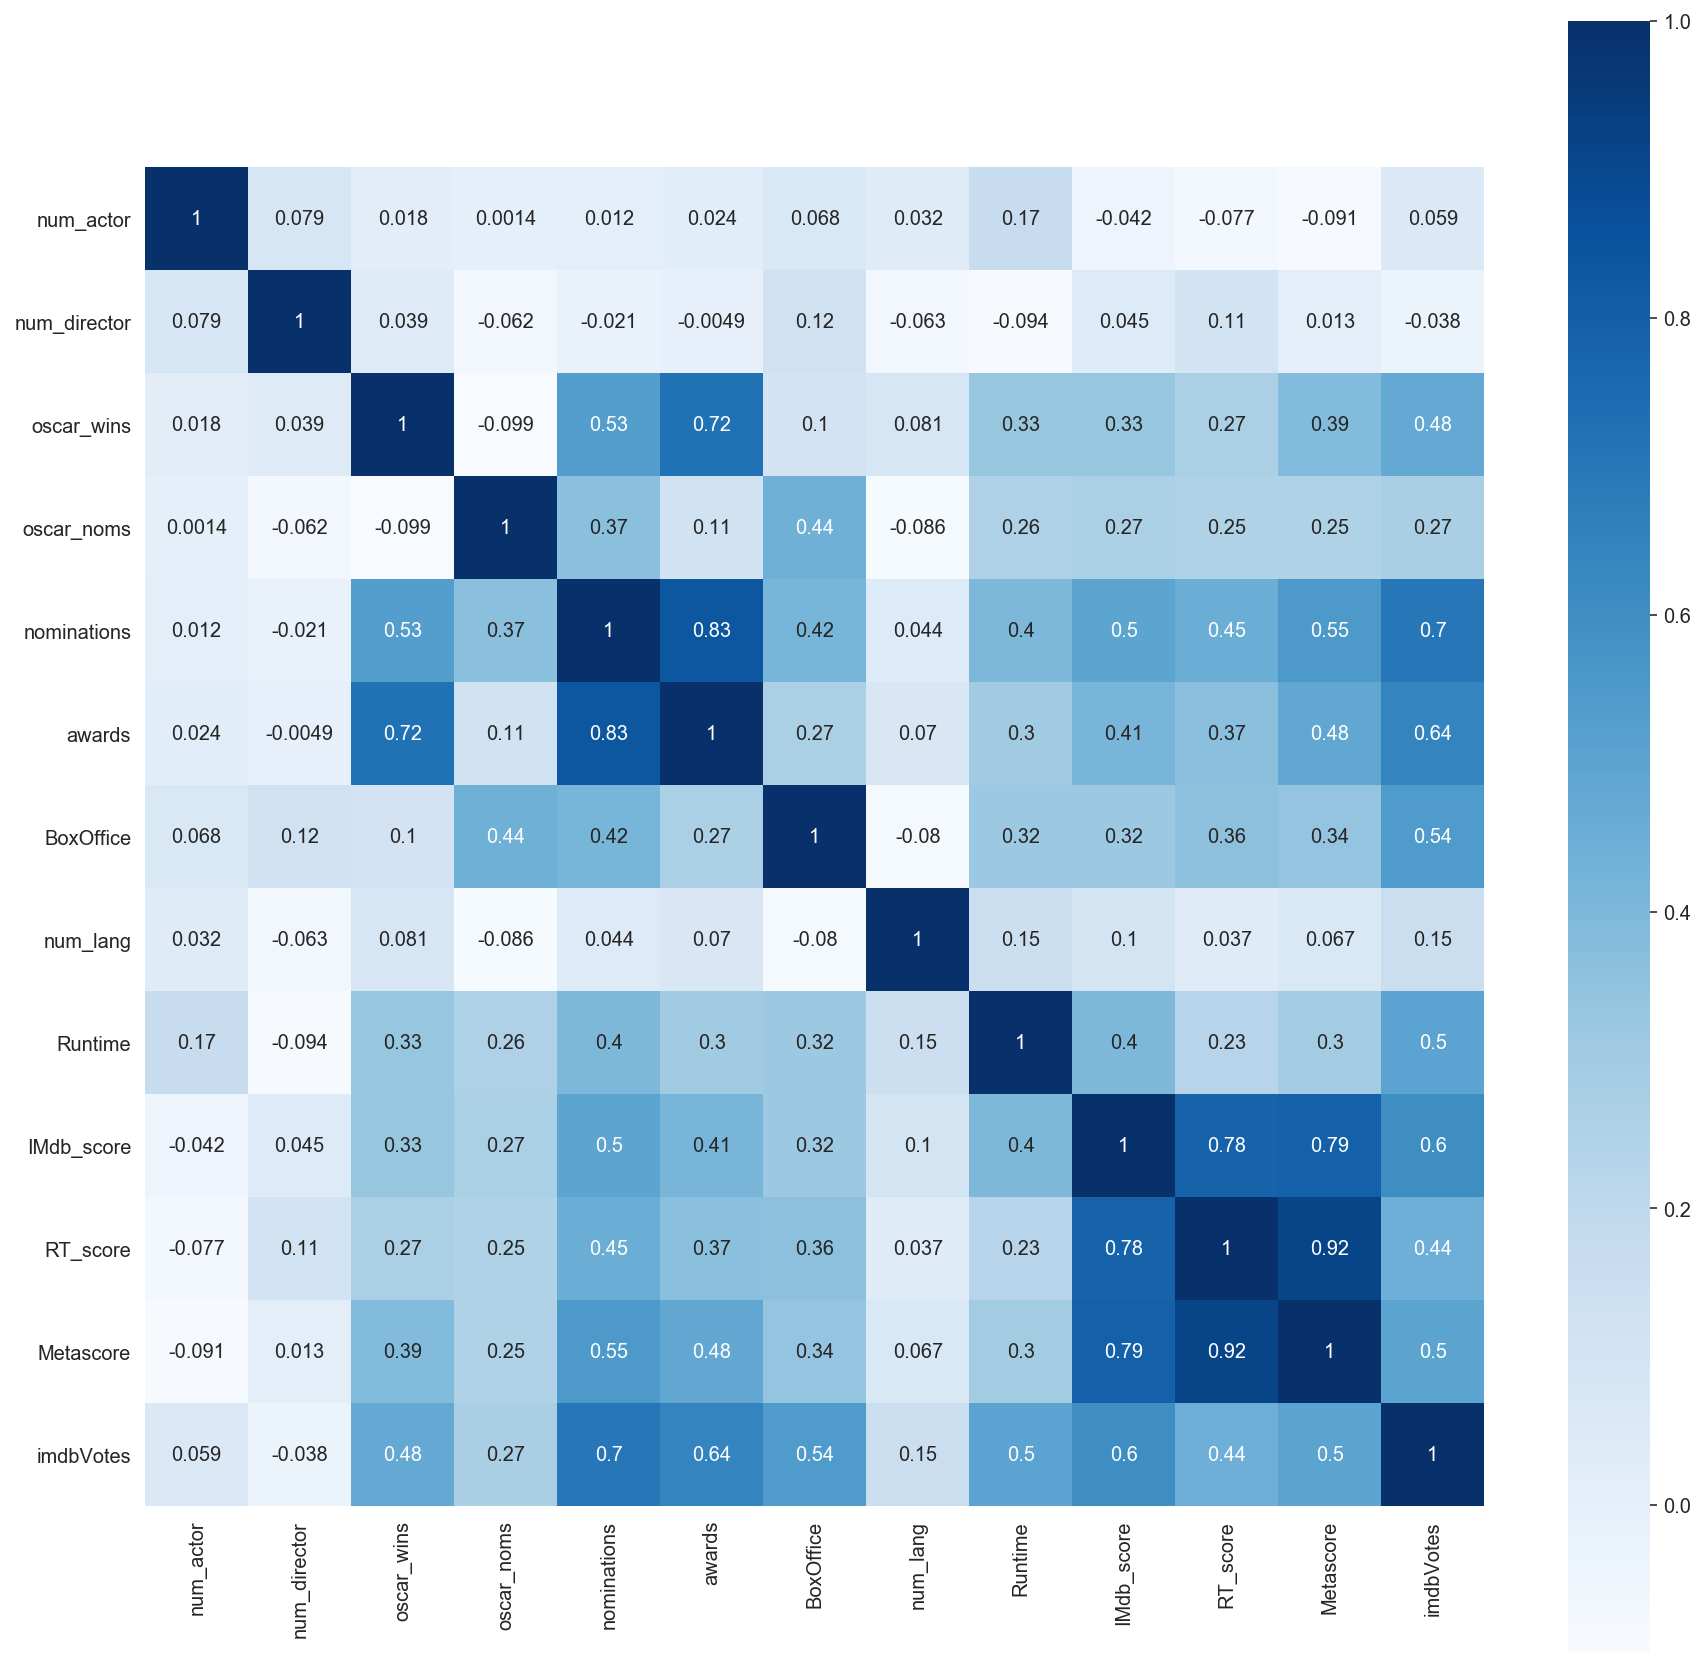

In [13]:
OMdb_num=OMdb[['num_actor','num_director','oscar_wins','oscar_noms','nominations','awards','BoxOffice',\
              'num_lang','Runtime','IMdb_score','RT_score','Metascore','imdbVotes']]

# Check correlation mat to see which features should be used for imputation # 
f,ax=plt.subplots(1,1,figsize=(15,15))
sns.heatmap(OMdb_num.corr(),cmap='Blues',square=True,annot=True)
plt.show()



From the correlation heatmap, it would appear that all three ratings are highly correlated with $\hat{\rho}$ above 0.75. However, I can't quite impute missing data with more missing data. There are a fair amount of co-occurring missing data for both Metascore and RT ratings. I'll just go with what seems like the best linear predictor of RT and Metacritic ratings, which is the IMdb ratings. 

In [16]:
print('There are {} co-occurrences of missing Metascore and RT ratings'.format(sum(OMdb['Metascore'].isnull()&OMdb['RT_score'].isnull())))

There are 40 co-occurrences of missing Metascore and RT ratings


In [17]:
# Drop 1 NA observation for IMdb score # 
main_X=OMdb['IMdb_score'].dropna()

# 1 column feature for predicting both meta and RT scores # 
X_meta=main_X[-OMdb['Metascore'].isnull()]
X_RT=main_X[-OMdb['RT_score'].isnull()]
X_meta=np.array(X_meta).reshape(-1,1)
X_RT=np.array(X_RT).reshape(-1,1)

# Response variable # 
y_meta=OMdb['Metascore'][-OMdb['Metascore'].isnull()]
y_RT=OMdb['RT_score'][-OMdb['RT_score'].isnull()]



In [18]:
# Simple Linear Regression to impute missing scores # 
lr=LinearRegression()

fit_meta=lr.fit(X_meta,y_meta)
fit_RT=lr.fit(X_RT,y_RT)

fill_meta=fit_meta.predict(np.array(main_X[OMdb['Metascore'].isnull()]).reshape(-1, 1))
fill_RT=fit_meta.predict(np.array(main_X[OMdb['RT_score'].isnull()]).reshape(-1, 1))



In [19]:
# Fill missing values # 
meta_index=main_X[OMdb['Metascore'].isnull()].index
RT_index=main_X[OMdb['RT_score'].isnull()].index
for i,a in enumerate(RT_index):
    OMdb.loc[a,'RT_score']=fill_RT[i]
for i,a in enumerate(meta_index):
    OMdb.loc[a,'Metascore']=fill_meta[i]

<h2> <a name="exploration"> 5. Exploration of relationships </a></h2>

Next, I'll be exploring some relationships within this dataset which. I'll be focusing the movies performance at the box office, as well as in the ratings. 

I also suspect that the studio and production house also determines in large part how well a movie does at the box office and with the critics, and in turn, its viability as a VOD title, so I'll be examining this further as well. 

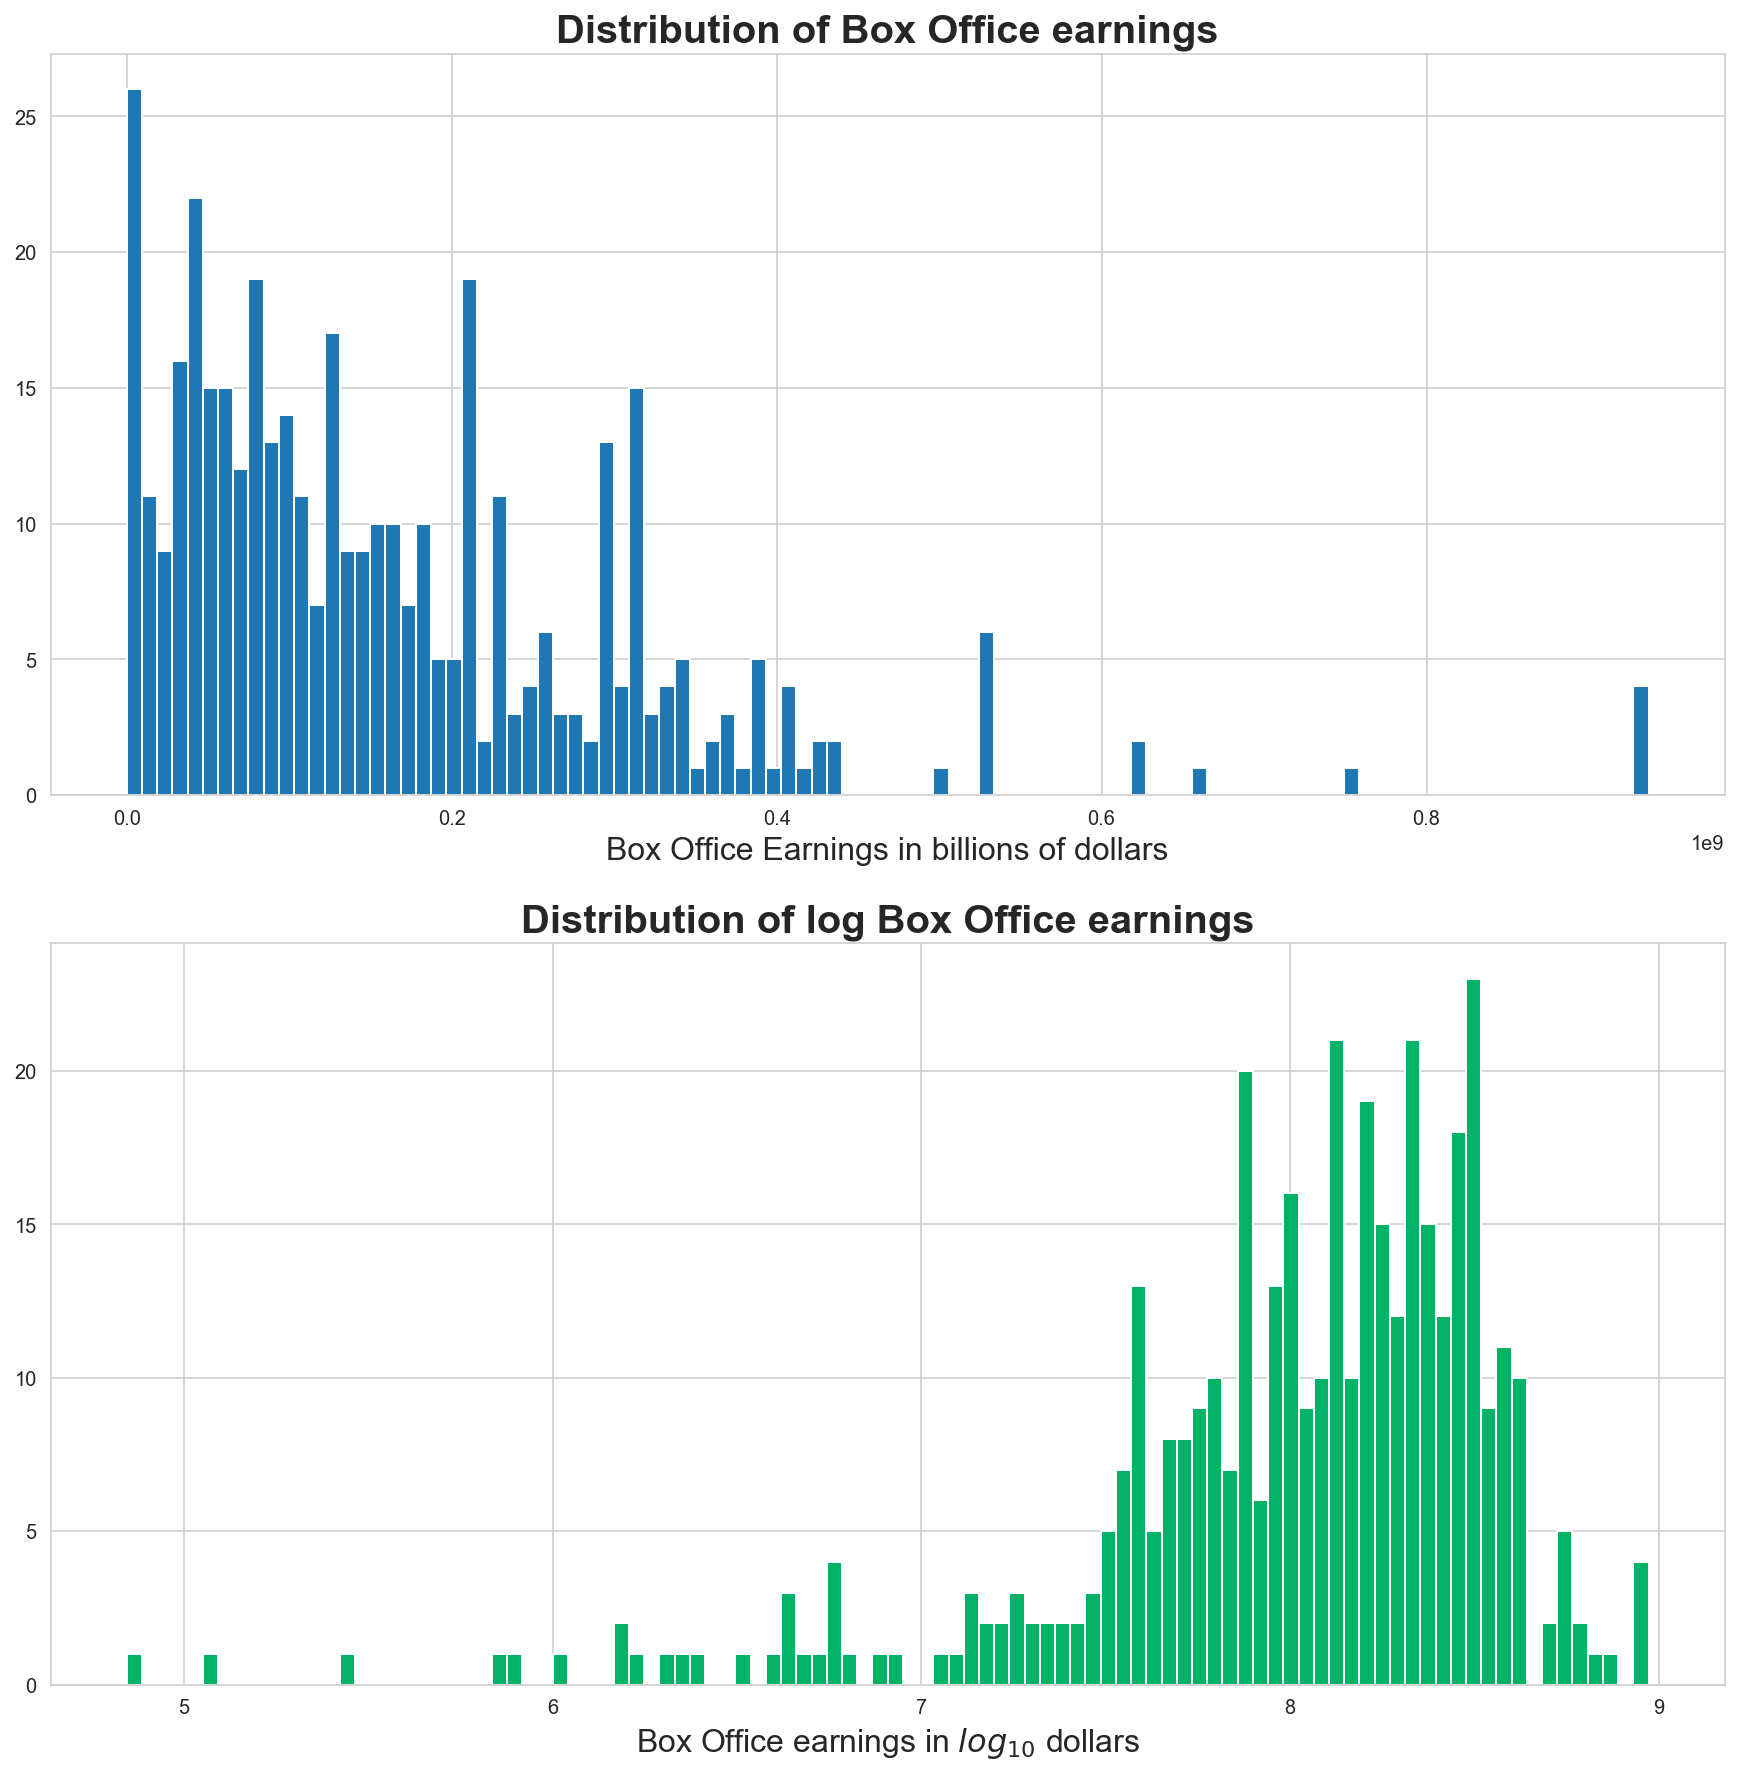

In [28]:
# Histogram of Box Office earnings and log box office earnings # 

plt.subplot(211)
ax1=OMdb['BoxOffice'].hist(bins=100,figsize=(15,15))
ax1.set_title('Distribution of Box Office earnings',fontsize=20,fontweight='bold')
ax1.set_xlabel('Box Office Earnings in billions of dollars',fontsize=16)

plt.subplot(212)
ax2=OMdb['BoxOffice'].apply(np.log10).hist(bins=100,figsize=(15,15),color=(0,0.7,0.4))
ax2.set_title('Distribution of log Box Office earnings',fontsize=20,fontweight='bold')
ax2.set_xlabel('Box Office earnings in $log_{10}$ dollars',fontsize=16)
plt.show()



I've transformed the box office earnings to a log scale to look closer at the mass concentrated around the 0-billion dollar mark. The log plot gives us a better sense of the distribution towards the lower end of the earnings distribution.

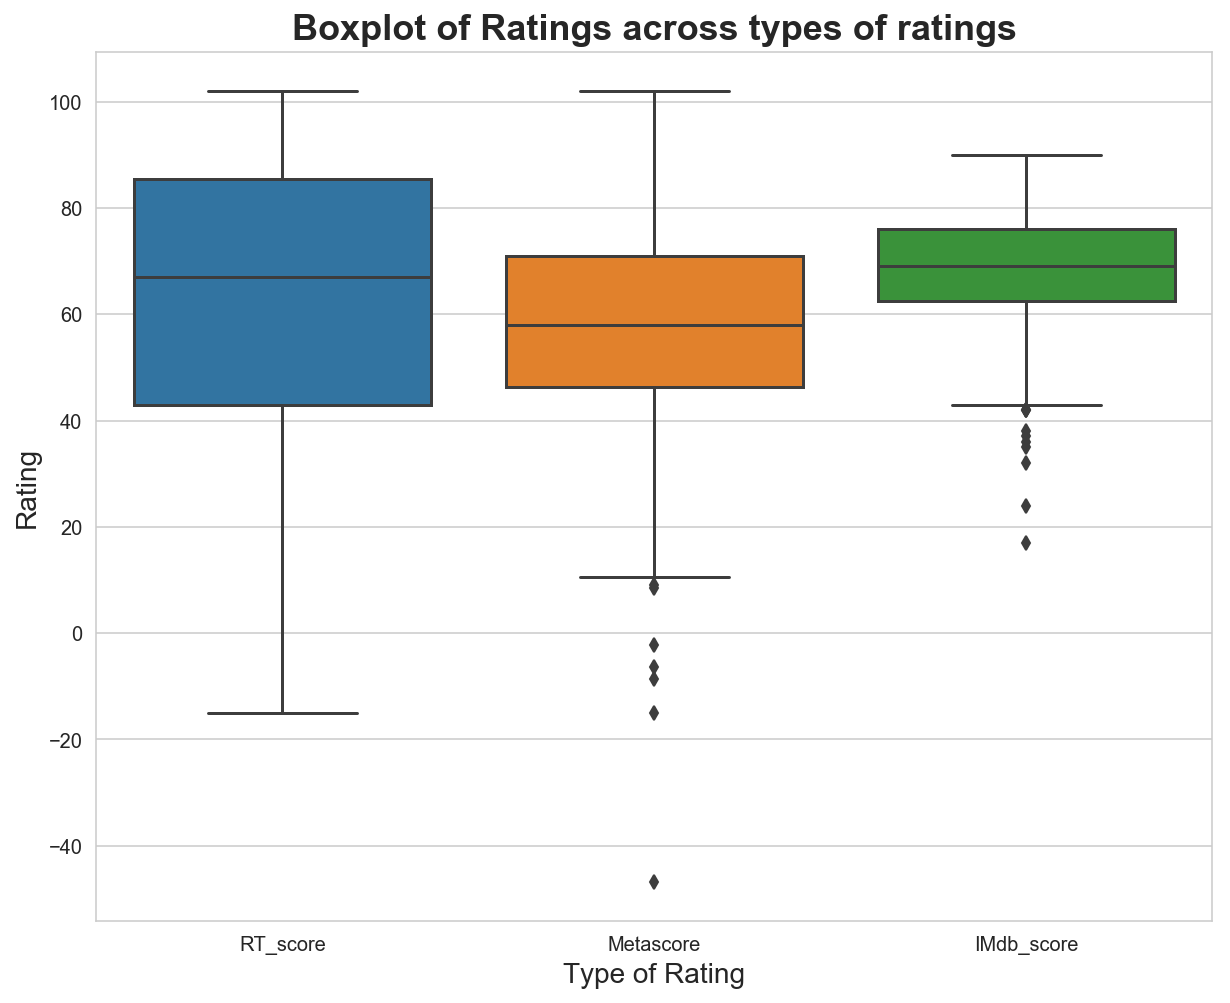

In [42]:
f, ax = plt.subplots(1,1,figsize=(10,8))
sns.boxplot(x='variable',y='value',data=pd.melt((OMdb[['RT_score','Metascore','IMdb_score']])))
ax.set_xlabel('Type of Rating',fontsize=14)
ax.set_ylabel('Rating',fontsize=14)
ax.set_title('Boxplot of Ratings across types of ratings',fontsize=18,fontweight='bold')
plt.show()

Overall, IMdb scores seem to be more consistent and have a narrower spread than Metascore ratings, which are less variable than Rotten Tomatoes ratings. RT scores are based on critic reviews, so it would not be surprising to see a wider spread of RT ratings here. 

In [ ]:
# Get top 10 studios by total earnings #
top_10_studios=OMdb['BoxOffice'].groupby(by=OMdb['Production']).sum()\
.sort_values(ascending=False).head(10).reset_index()['Production']

# Boolean to subset the data for movies produced by the top 10 studios by total earnings # 
top10=OMdb['Production'].isin(top_10_studios)


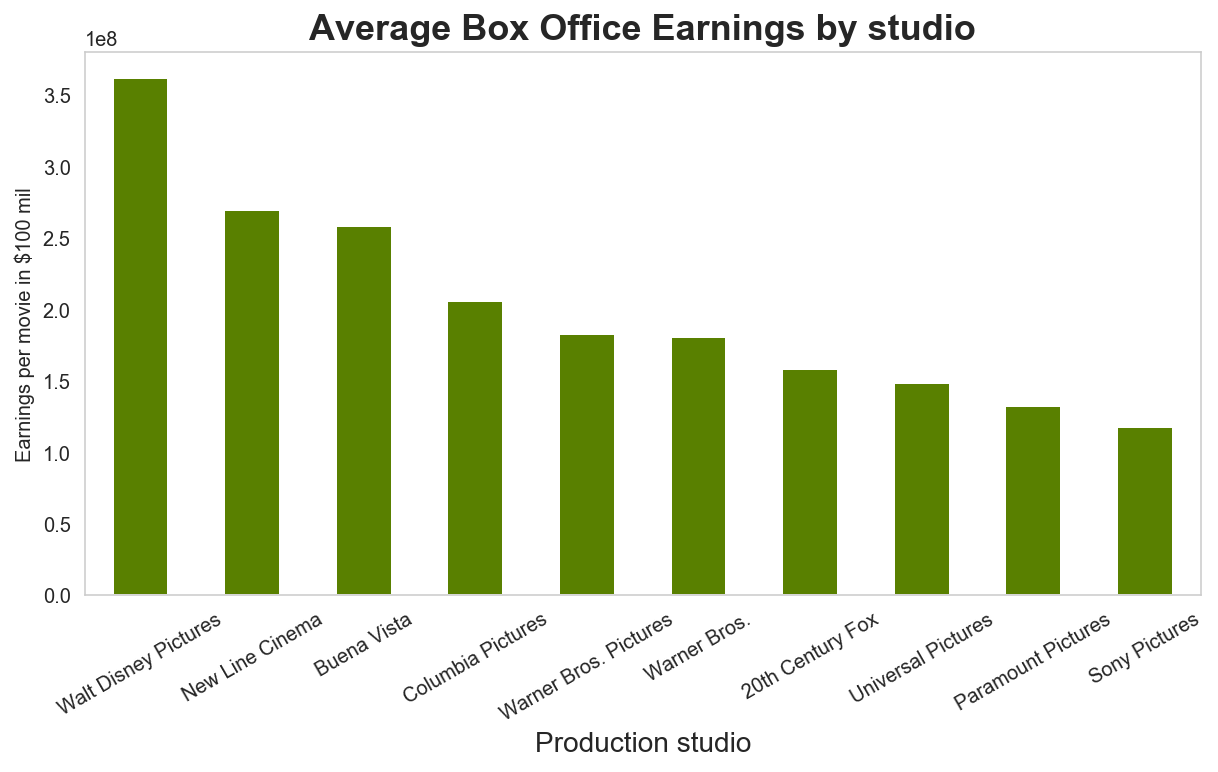

In [74]:
# Barplot of earnings by studio # 
ax= OMdb['BoxOffice'][top10].groupby(by=OMdb['Production'][top10]).mean().sort_values(ascending=False).plot.bar(rot=30, color=(0.35,0.5,0),figsize=(10,5))
ax.set_xlabel('Production studio',fontsize=14)
ax.set_ylabel('Earnings per movie in $100 mil',fontsize=10)
ax.set_title('Average Box Office Earnings by studio',fontsize=18,fontweight='bold')
ax.grid(False)
plt.show()

Wlat Disney appears to be the top ranking studio by average earnings per movie, but Warner Bros, currently split into two categories, would appear to be top if the two categories were merged. It's useful to get an idea of how consistent the studios are in producing high earning movies, and the amount of leverage and bargaining power they would have by virtue of market share.

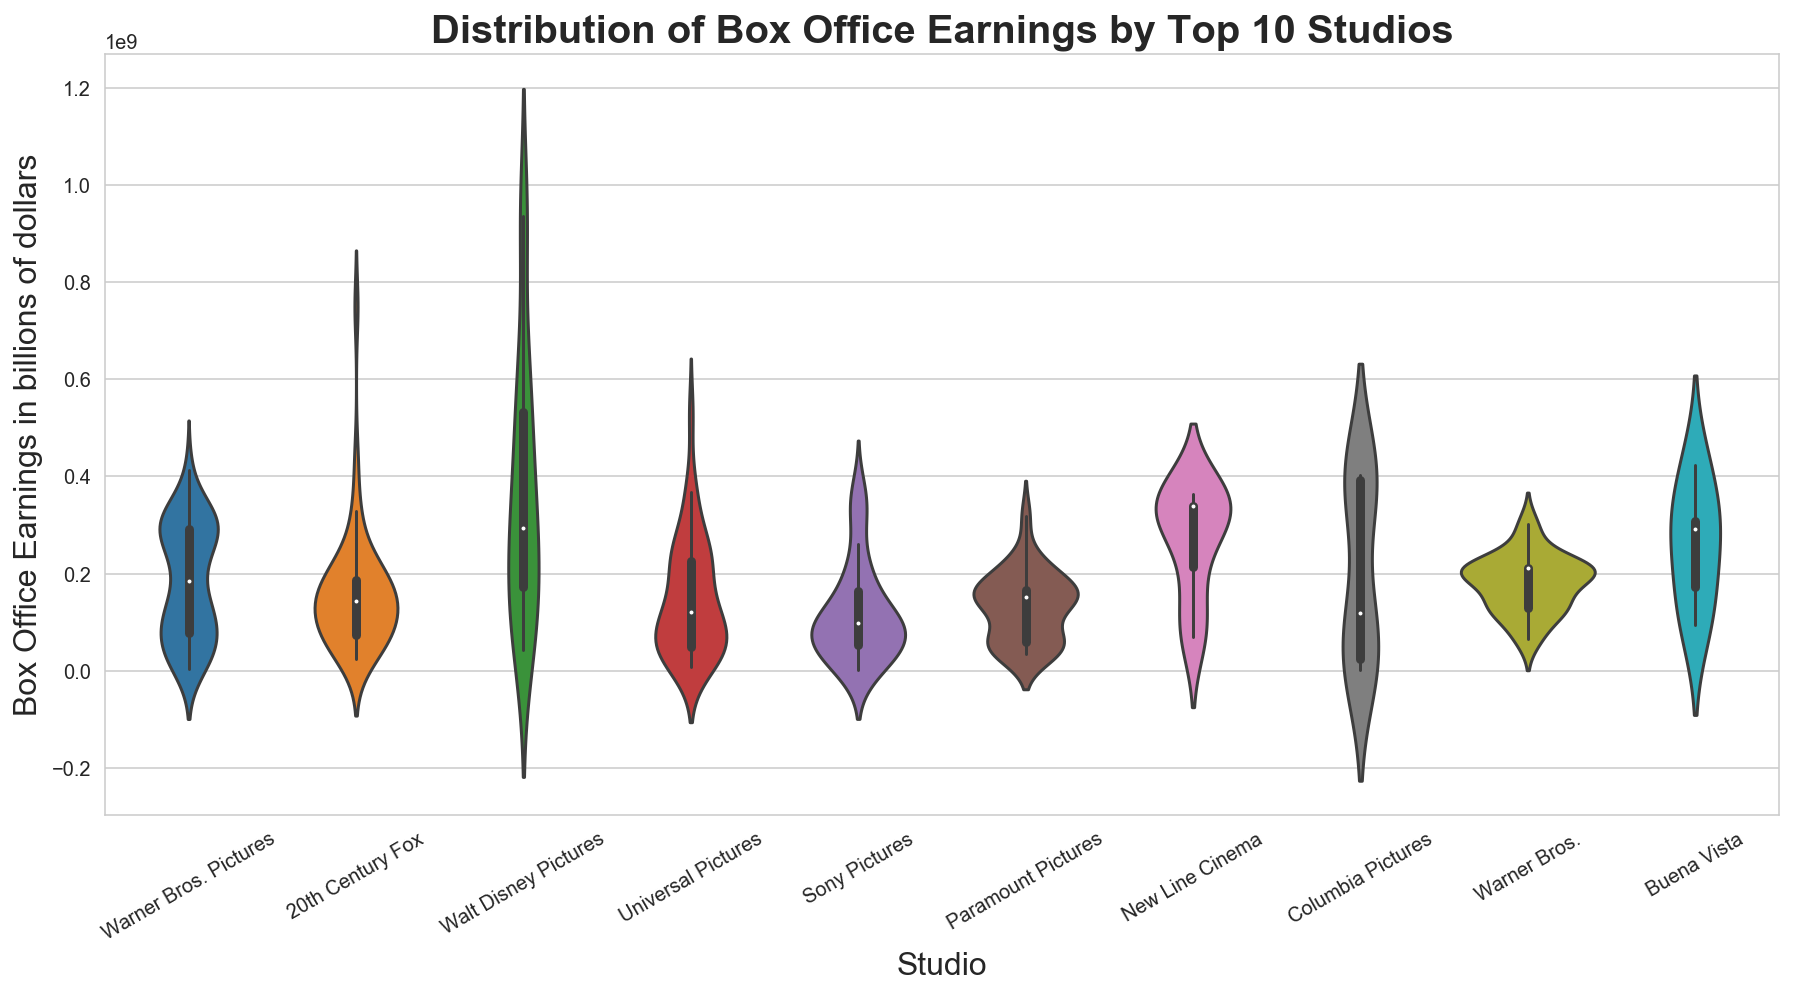

In [75]:

# Do a violin plot # 
f,ax=plt.subplots(1,1,figsize=(15,7))
sns.violinplot(data=OMdb[top10], x='Production',y='BoxOffice')
labels=ax.get_xmajorticklabels()
ax.set_xticklabels(labels,rotation=30)
ax.set_title('Distribution of Box Office Earnings by Top 10 Studios',fontsize=20,fontweight='bold')
ax.set_xlabel('Studio',fontsize=16)
ax.set_ylabel('Box Office Earnings in billions of dollars',fontsize=16)
plt.show()

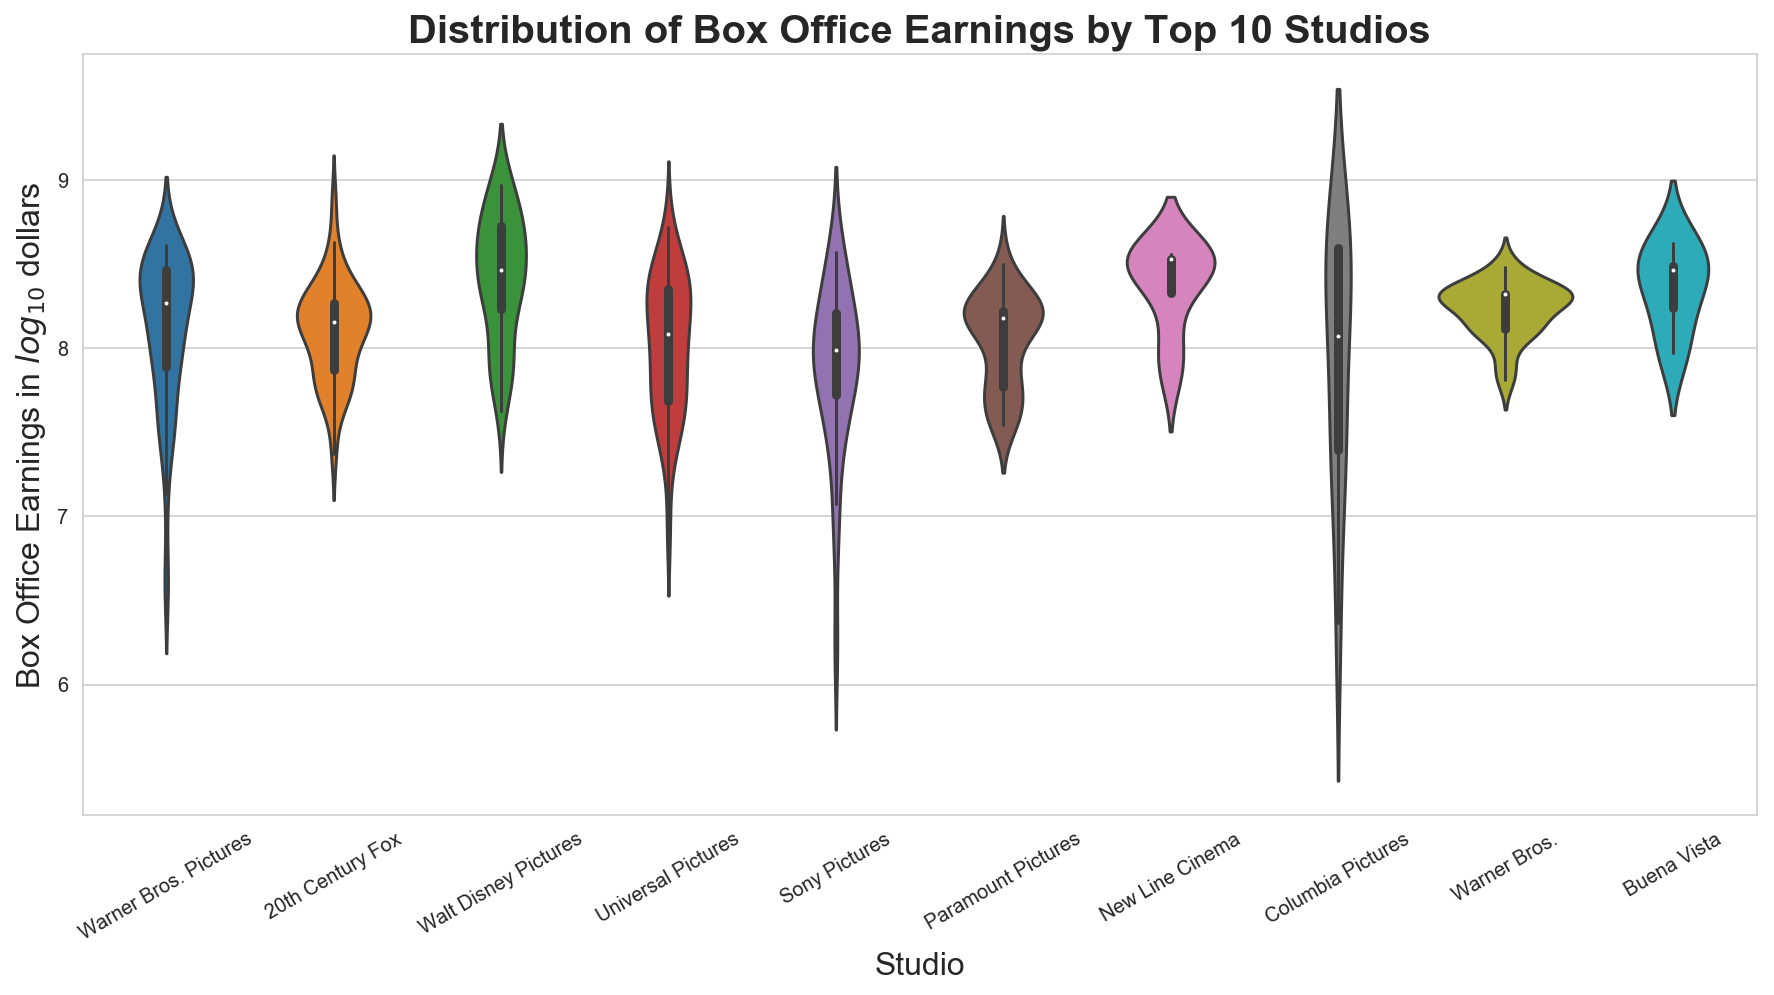

In [77]:
# Violin plot for log earnings # 
f,ax=plt.subplots(1,1,figsize=(15,7))

OMdb['logBoxOffice']=OMdb['BoxOffice'].apply(np.log10)
sns.violinplot(data=OMdb[top10], x='Production',y='logBoxOffice')
labels=ax.get_xmajorticklabels()
ax.set_xticklabels(labels,rotation=30)
ax.set_title('Distribution of Box Office Earnings by Top 10 Studios',fontsize=20,fontweight='bold')
ax.set_xlabel('Studio',fontsize=16)
ax.set_ylabel('Box Office Earnings in $log_{10}$ dollars',fontsize=16)
plt.show()


Comparing log box office earnings, we can see that studios have a fairly comparable level of earnings but the consistency at which they can achieve that varies across studios. Warner Bros, 20th Century Fox and New Line Cinemas for instance, are more consistent than Columbia and Sony Pictures in their box office gross.

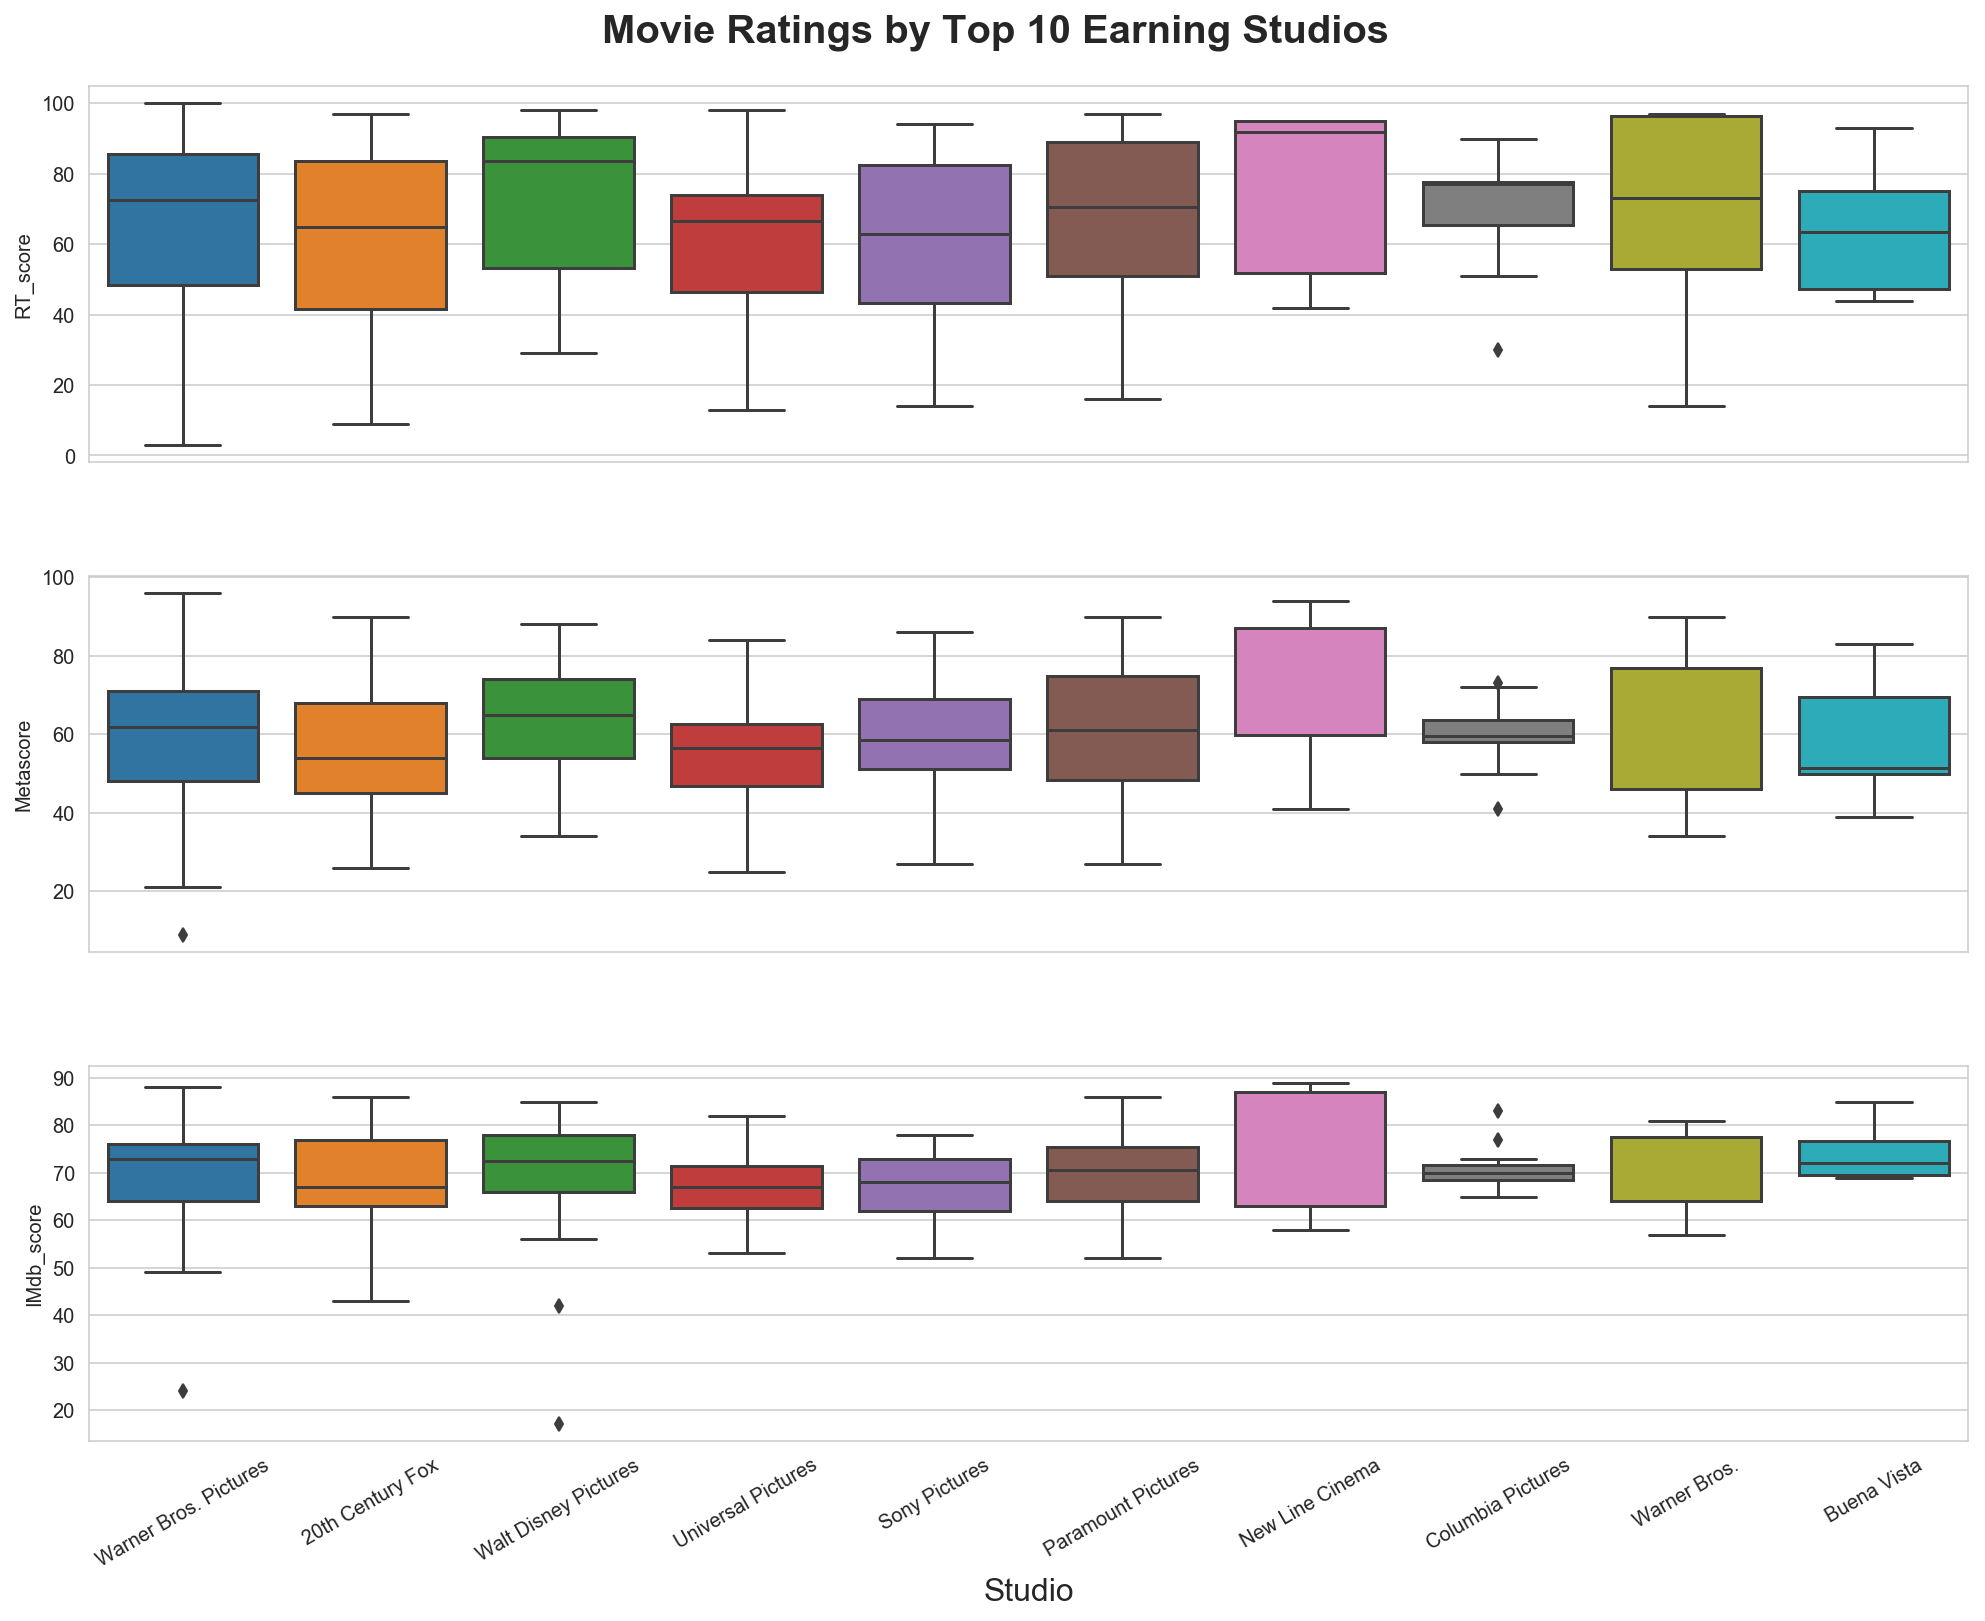

In [406]:
f,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(15,12=),sharex=True)
sns.boxplot(data=OMdb[OMdb['Production'].isin(top_10_studios)], x='Production',y='RT_score',ax=ax1)
sns.boxplot(data=OMdb[OMdb['Production'].isin(top_10_studios)], x='Production',y='Metascore',ax=ax2)
sns.boxplot(data=OMdb[OMdb['Production'].isin(top_10_studios)], x='Production',y='IMdb_score',ax=ax3)
ax1.set_xlabel('')
ax2.set_xlabel('')
labels=ax3.get_xmajorticklabels()
ax3.set_xticklabels(labels,rotation=30)
ax3.set_xlabel('Studio',fontsize=16)
f.suptitle('Movie Ratings by Top 10 Earning Studios',fontsize=20,fontweight='bold')
f.tight_layout(pad=5)

plt.show()



We observe a similar pattern for ratings when broken down aross studios. Most studios have a more consistent IMdb score and Metacritic score than RT score. There doesn't seem to be a studio that performs significantly better when pleasing the movie raters! 

In [78]:
OMdb_engineered=OMdb[['num_actor','num_director','oscar_wins','oscar_noms',\
                      'nominations','awards','num_lang','num_genre']]


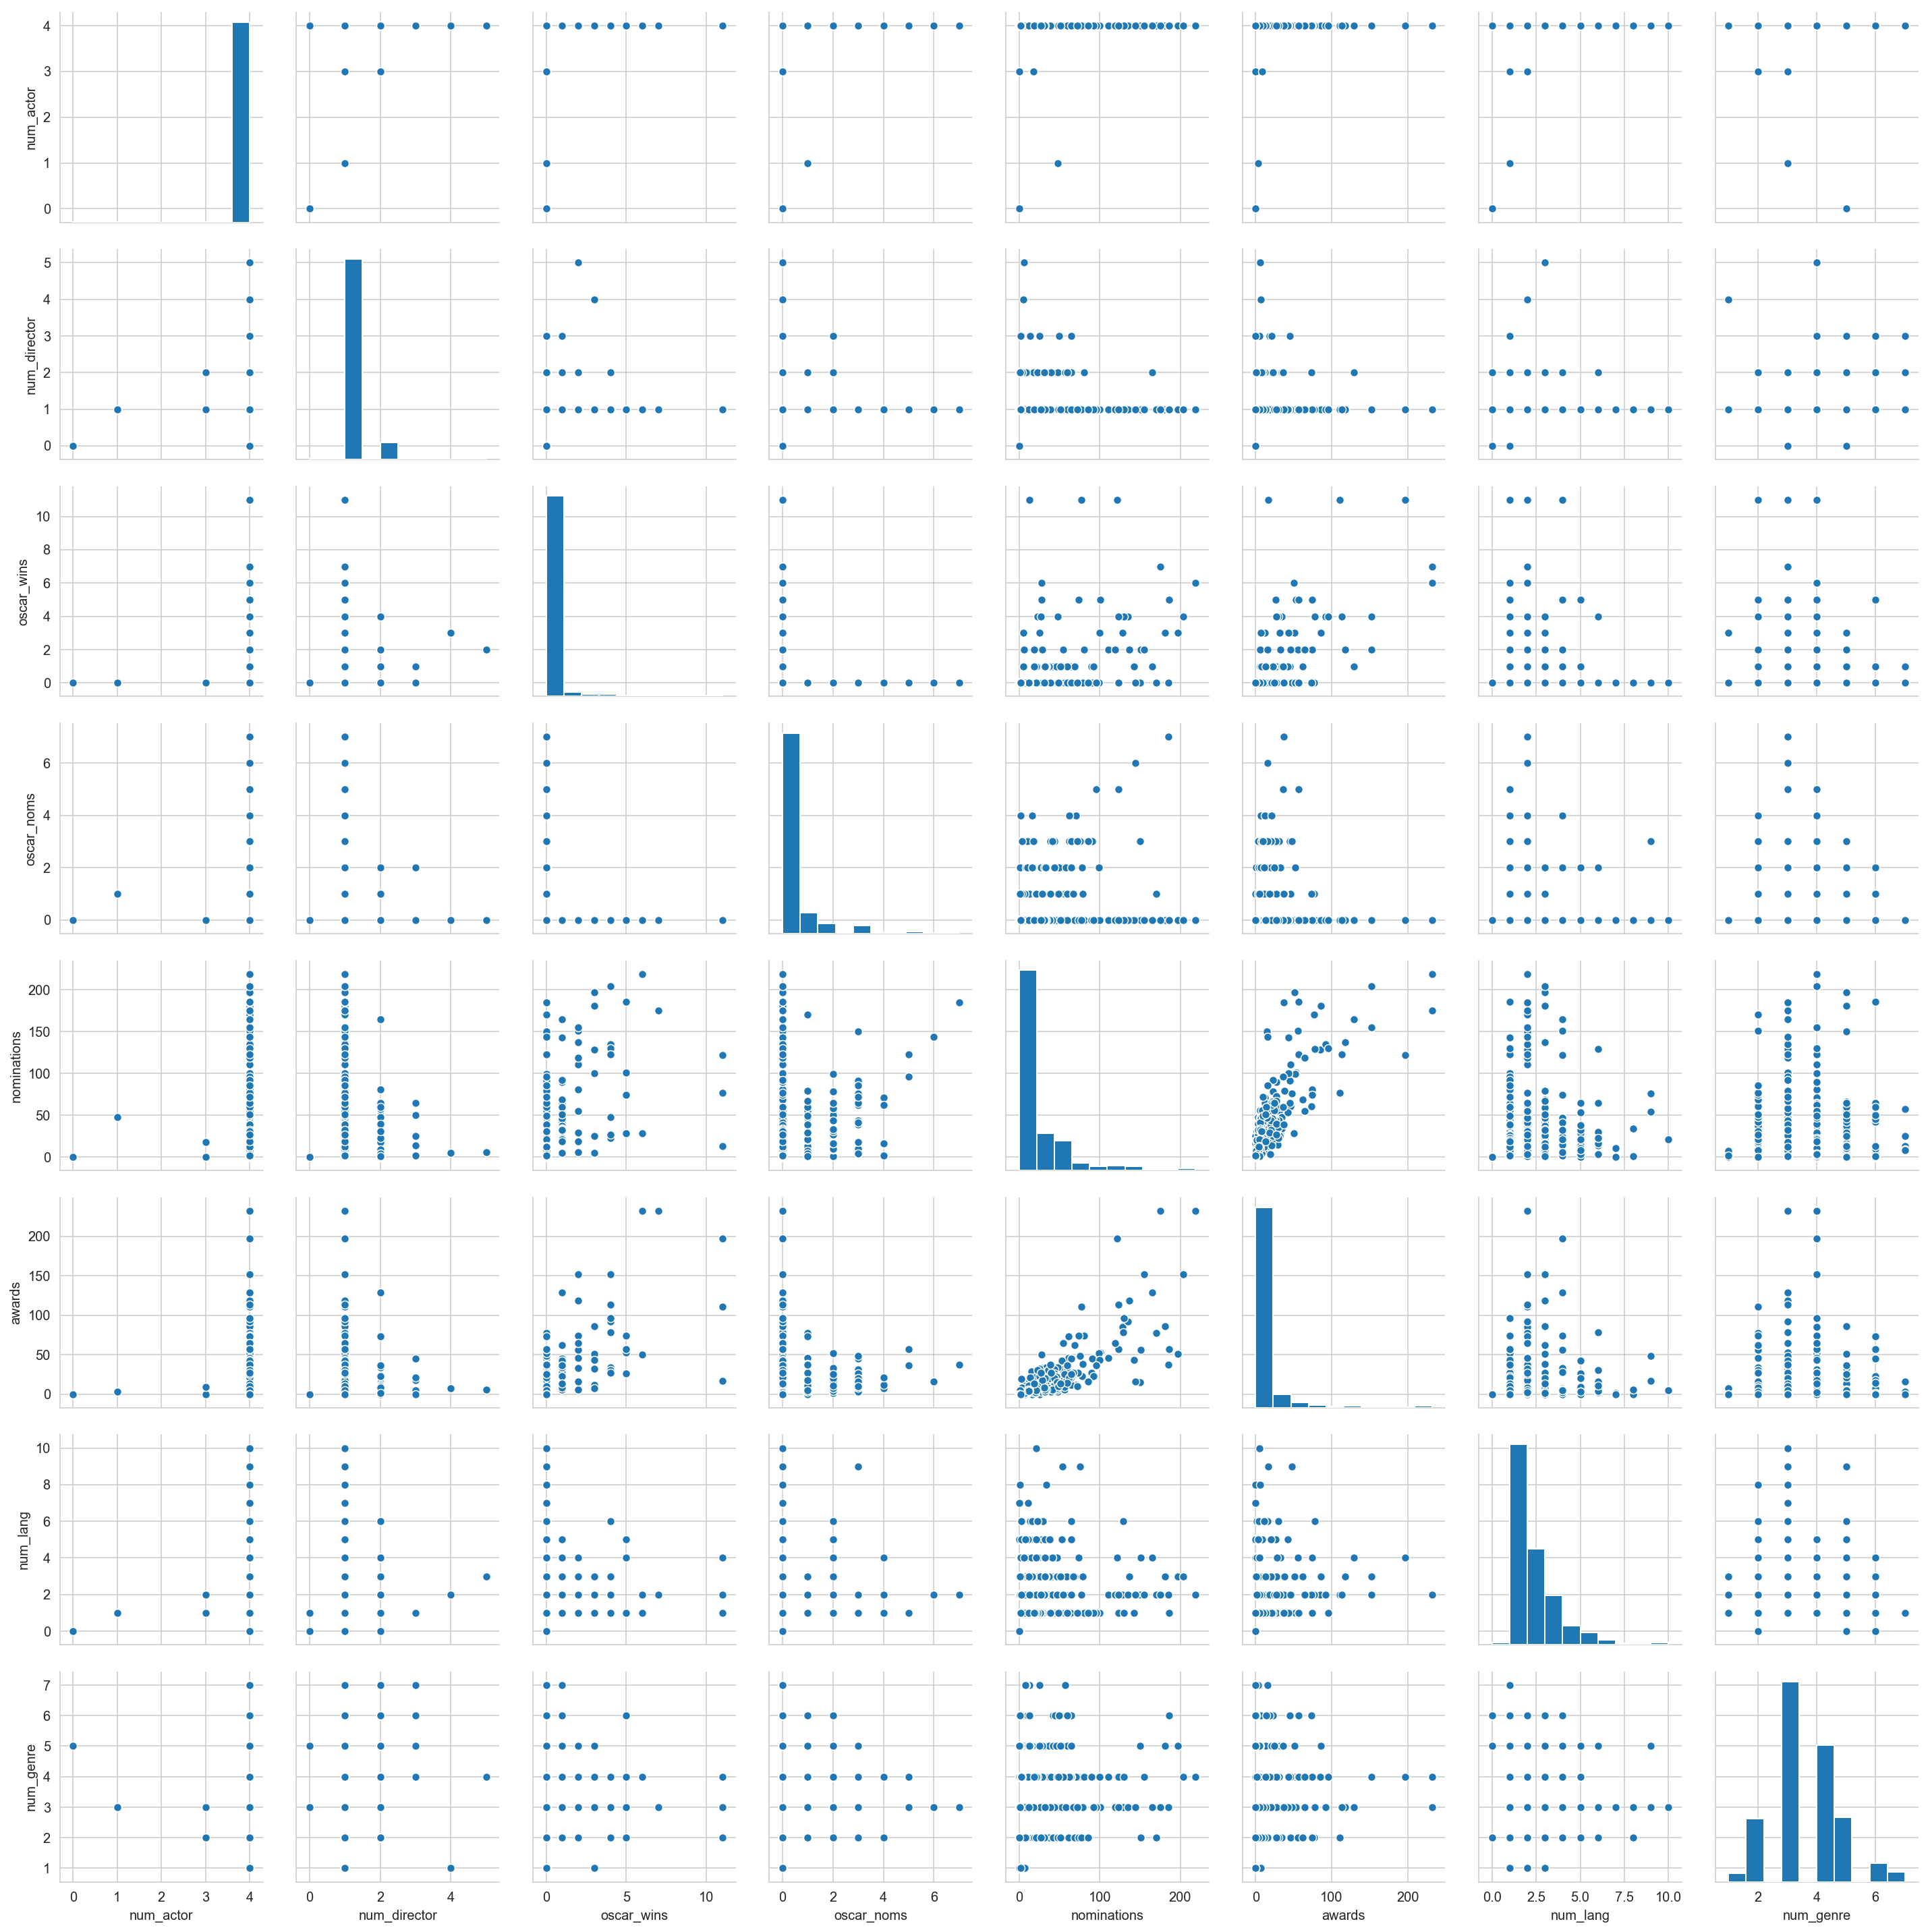

In [79]:
sns.pairplot(OMdb_engineered.fillna(0))



Looking at my engineered features, there appears to be no real relationship between these variables. Given variables such as number of actors, number of genres and oscar wins are low in number, I may consider tranforming this to a dummy variable later like whether a film won an award, or whether it got nominated etc. 

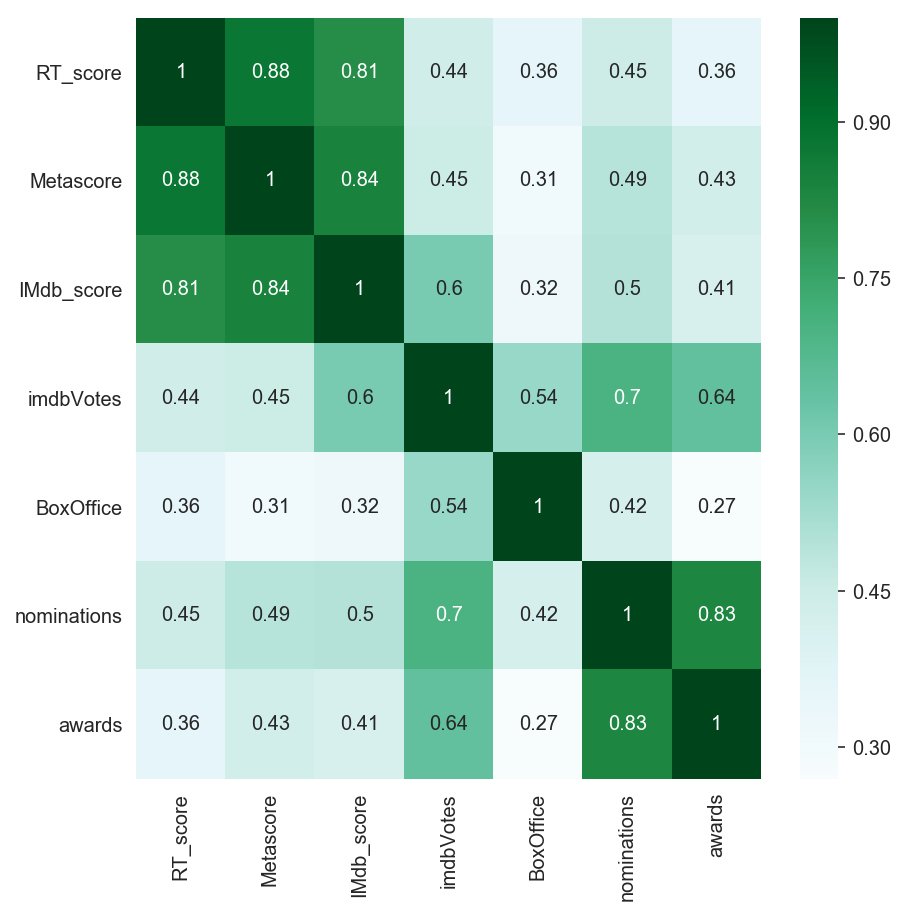

In [89]:
OMdb_performance=OMdb[['RT_score','Metascore','IMdb_score','imdbVotes','BoxOffice','nominations','awards']]
f,ax=plt.subplots(1,1,figsize=(7,7))
sns.heatmap(OMdb_performance.corr(),cmap="BuGn",annot=True)

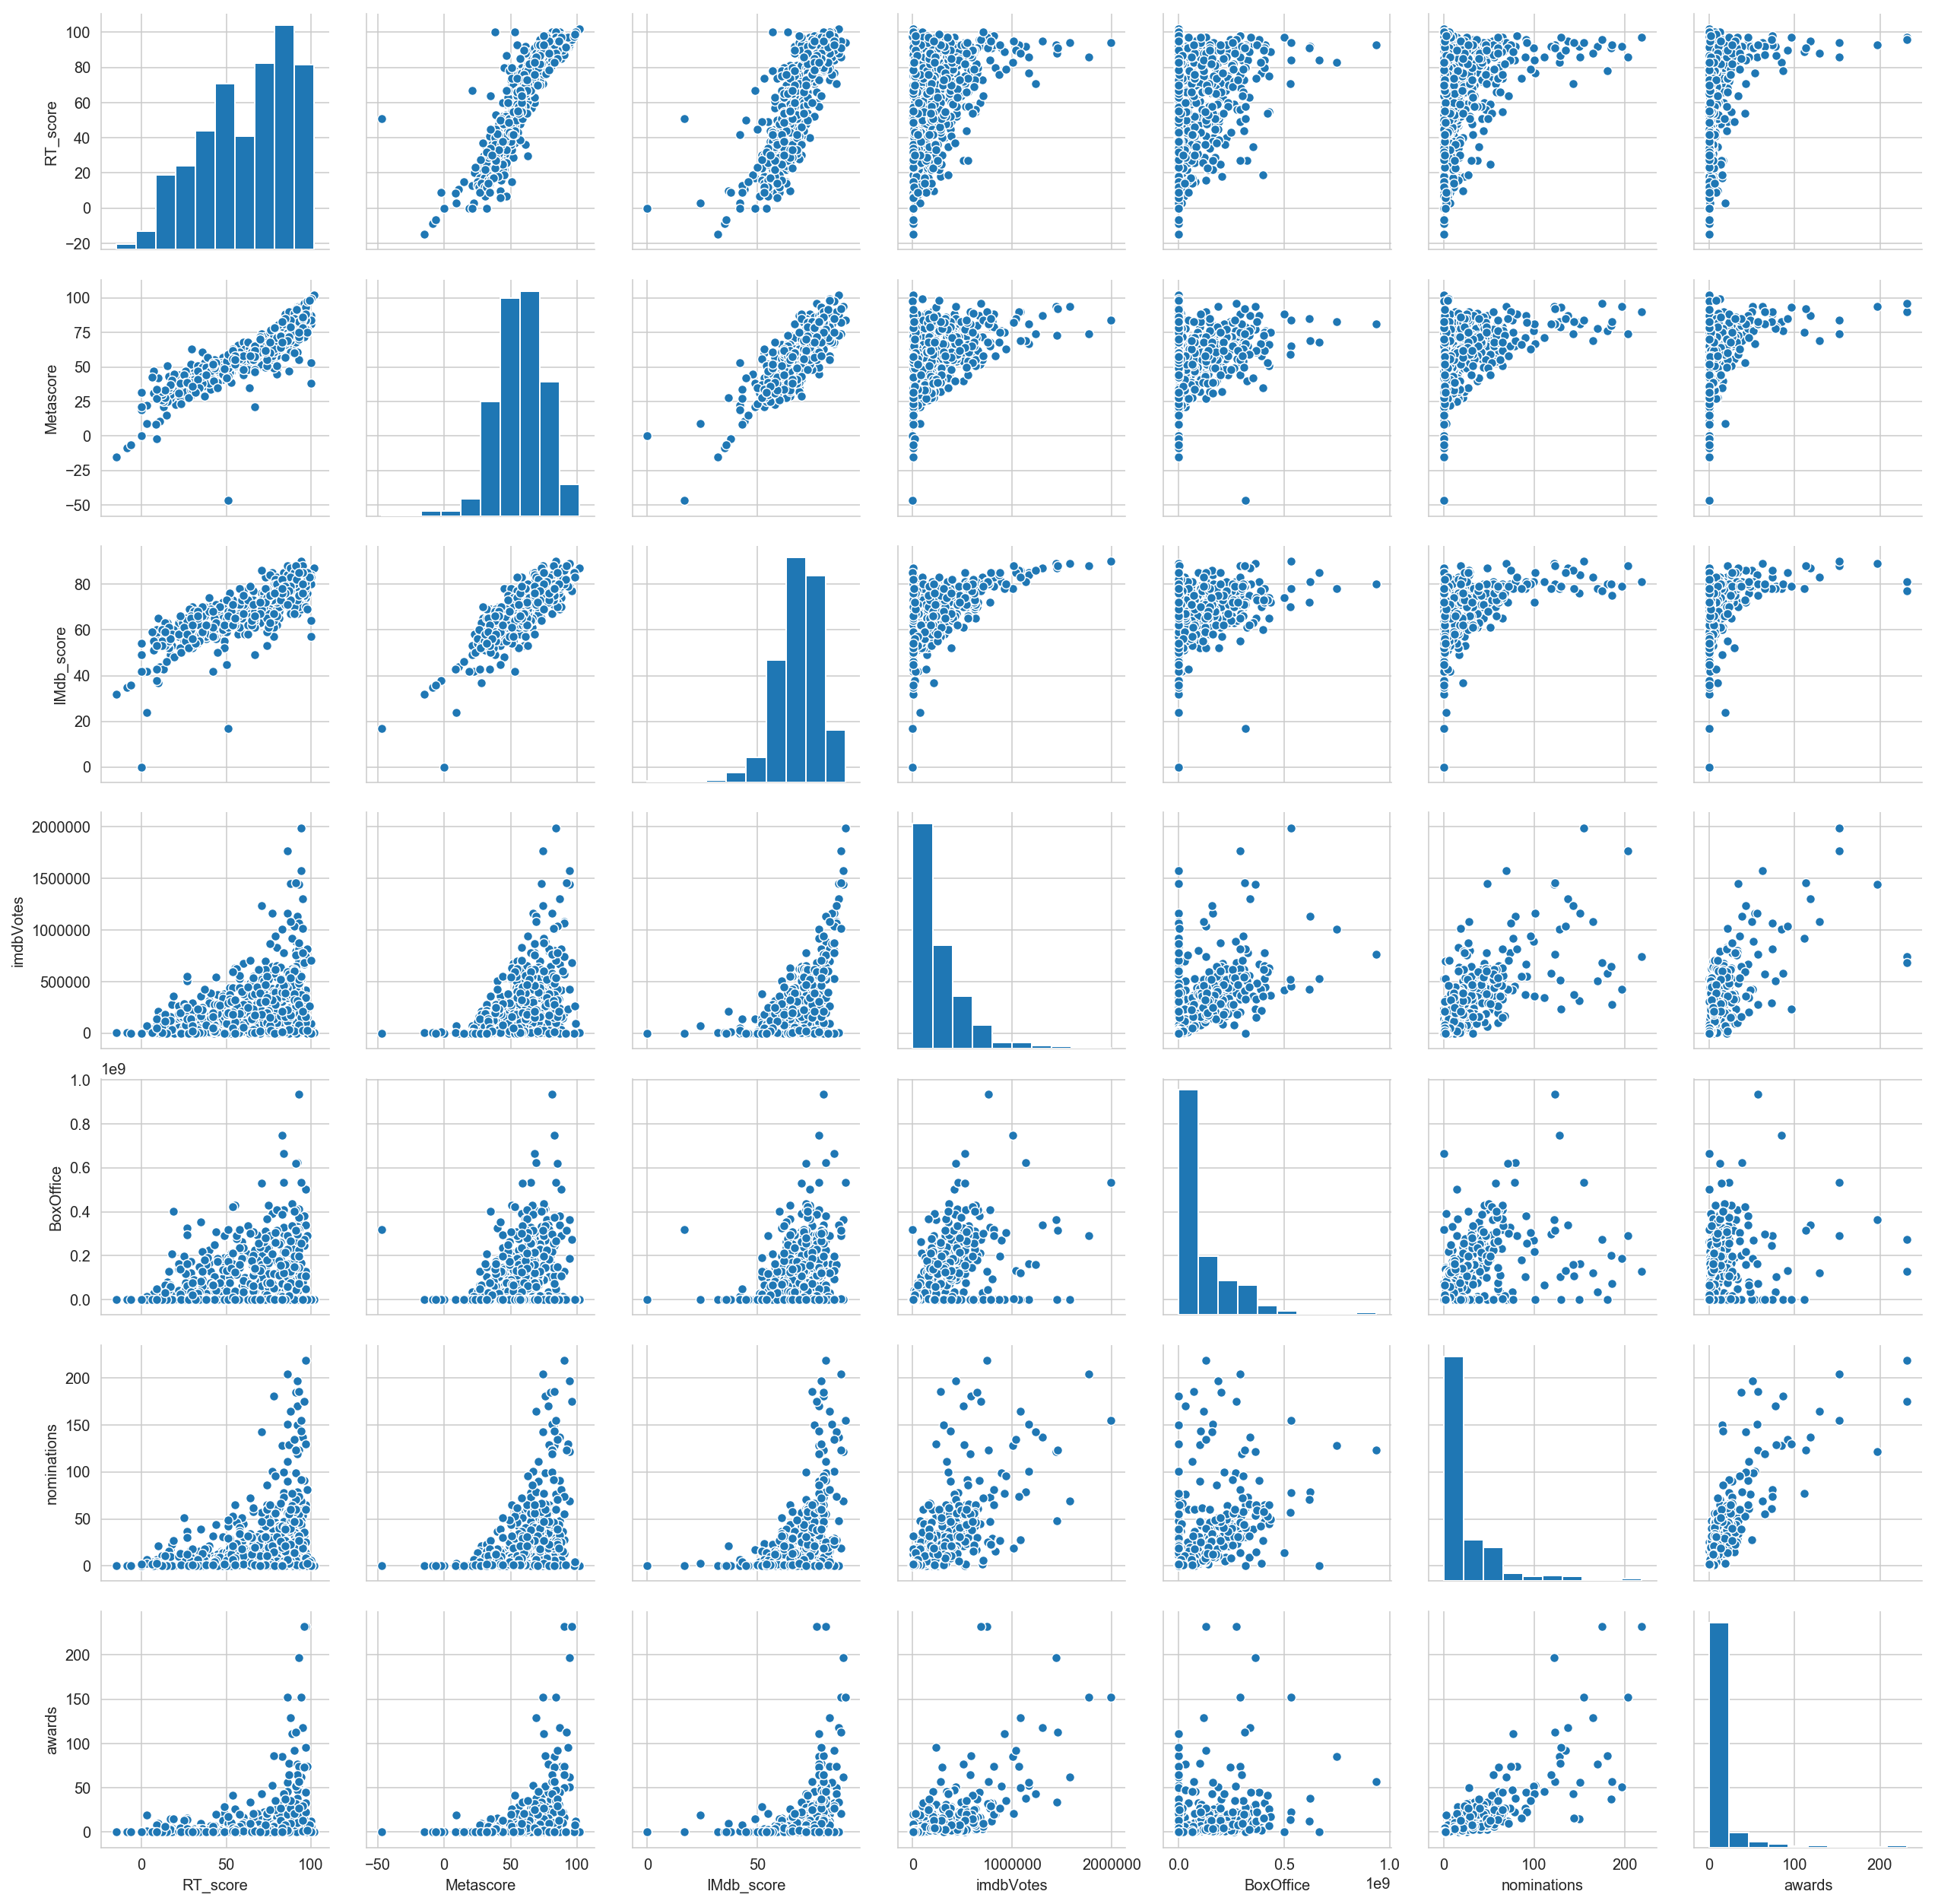

In [88]:
sns.pairplot(OMdb[['RT_score','Metascore','IMdb_score','imdbVotes','BoxOffice','nominations','awards']].fillna(0))

The relationship between the 'performance' metrics, eg. Box office earnings, ratings and awards are all non-zero. My hypothesis is that a film's performance will drive its pricing on a VOD platform. This could lead to some type of PCA somewhere down the line, especially for the critic ratings scores. 

<h2><a name="discussion"> 6. Discussion</a></h2>

Next, I'll be moving on to merge the OMdb data and the iTunes data. Nonetheless, there is good potential for further work going off this dataset alone. For instance, can we predict how well a movie performs at the box office given what we know about its ratings, or cast, or breaking down the plot synopsis?

I'll also be returning to this dataset to do some text analytics given the time. Check back for more updates.